In [ ]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
# 载入数据
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

In [ ]:
# 批次的大小
batch_size = 128
n_batch = mnist.train.num_examples // batch_size

# 参数概要
def variable_summaries(var):
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean',mean) # 平均值
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev',stddev) # 标准差
        tf.summary.scalar('max', tf.reduce_max(var)) # 最大值
        tf.summary.scalar('min', tf.reduce_min(var)) # 最小值
        tf.summary.histogram('histogram',var) # 直方图


# 命名空间
with tf.name_scope('input'):
    x = tf.placeholder(tf.float32, [None,784],name="X-input")
    y = tf.placeholder(tf.float32, [None, 10],name='y-input')
    # 创建一个简单的神经网络
with tf.name_scope('layer'):
    with tf.name_scope('weights'):
        W = tf.Variable(tf.zeros([784,10]),name='W')
        variable_summaries(W)
    with tf.name_scope('biases'):
        b = tf.Variable(tf.zeros([1, 10]),name='b')
        variable_summaries(b)
    with tf.name_scope('xw_plus_b'):
        wx_plus_b = tf.matmul(x,W) + b
    with tf.name_scope('softmax'):
        prediction = tf.nn.softmax(wx_plus_b)

# 代价函数
with tf.name_scope('loss'):
    loss = tf.reduce_mean(tf.square(y-prediction))
    tf.summary.scalar('loss', loss)
# 梯度下降法
with tf.name_scope('train'):
    train_step = tf.train.GradientDescentOptimizer(0.2).minimize(loss)
    
# 初始化变量
init = tf.global_variables_initializer()

# 得到一个布尔型列表，存放结果是否正确
with tf.name_scope('accuracy'):
    with tf.name_scope('correct_prediction'):
        correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(prediction,1)) #argmax 返回一维张量中最大值索引
    # 求准确率
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32)) # 把布尔值转换为浮点型求平均数
        tf.summary.scalar('accuracy', accuracy)
# 合并所有summary
merged = tf.summary.merge_all()
        
with tf.Session() as sess:
    sess.run(init)
    writer = tf.summary.FileWriter('logs/',sess.graph)
    for epoch in range(51):
        for batch in range(n_batch):
            # 获得批次数据
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            # 运行网络并记录log
            summary,_ = sess.run([merged, train_step], feed_dict={x:batch_xs, y:batch_ys})
        # 记录变量
        writer.add_summary(summary,epoch)
        acc = sess.run(accuracy, feed_dict={x:mnist.test.images,y:mnist.test.labels})
        print("Iter " + str(epoch) + " Testing Accuracy: " + str(acc))
    writer.close()
    writer.close()

Another example

In [ ]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
# 载入数据
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

In [ ]:
max_step = 1000
learning_rate = 0.001
dropout = 0.9

log_dir = "Logs/log-5.3"

with tf.name_scope('input'):
    x = tf.placeholder(tf.float32, [None, 784], name='x-input')
    y_ = tf.placeholder(tf.float32, [None, 10], name='y-input')
    keep_prob = tf.placeholder(tf.float32)
    
with tf.name_scope('input_reshape'):
    image_shaped_input = tf.reshape(x, [-1, 28, 28, 1])
    tf.summary.image('input', image_shaped_input, 10)
    
def weight_variable(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1))

def bias_variable(shape):
    return tf.Variable(tf.constant(0.1, shape=shape))
def variable_summaries(var):
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var-mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)
        
def nn_layer(input_tensor, input_dim, output_dim, layer_name, act=tf.nn.relu):
    with tf.name_scope(layer_name):
        with tf.name_scope('weights'):
            weights = weight_variable([input_dim, output_dim])
            variable_summaries(weights)
        with tf.name_scope('biases'):
            biases = bias_variable([output_dim])
            variable_summaries(biases)
        with tf.name_scope('linear_compute'):
            preactivate = tf.matmul(input_tensor, weights) + biases
            tf.summary.histogram('linear', preactivate)
        activations = act(preactivate, name='activation')
        tf.summary.histogram('activations', activations)
        
        return activations

In [ ]:
hidden1 = nn_layer(x, 784, 500, 'layer1')

with tf.name_scope('dropout'):
    tf.summary.scalar('keep_probability', keep_prob)
    dropped = tf.nn.dropout(hidden1, keep_prob)

# 创建一个输出层，输入的维度是上一层的输出:500,输出的维度是分类的类别种类：10，
# 激活函数设置为全等映射identity.（暂且先别使用softmax,会放在之后的损失函数中一起计算）
y = nn_layer(dropped, 500, 10, 'layer2', act=tf.identity)

with tf.name_scope('loss'):
    # 计算交叉熵损失（每个样本都会有一个损失）
    diff = tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y)
    with tf.name_scope('total'):
      # 计算所有样本交叉熵损失的均值
      cross_entropy = tf.reduce_mean(diff)

tf.summary.scalar('loss', cross_entropy)

with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
    
with tf.name_scope('accuracy'):
    with tf.name_scope('correct_prediction'):
      # 分别将预测和真实的标签中取出最大值的索引，弱相同则返回1(true),不同则返回0(false)
      correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
    with tf.name_scope('accuracy'):
      # 求均值即为准确率
      accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
tf.summary.scalar('accuracy', accuracy)
# summaries合并
merged = tf.summary.merge_all()


def feed_dict(train):
    """Make a TensorFlow feed_dict: maps data onto Tensor placeholders."""
    if train:
        xs, ys = mnist.train.next_batch(100)
        k = dropout
    else:
        xs, ys = mnist.test.images, mnist.test.labels
        k = 1.0
    return {x: xs, y_: ys, keep_prob: k}

with tf.Session() as sess:
    # 写到指定的磁盘路径中
    train_writer = tf.summary.FileWriter(log_dir + '/train', sess.graph)
    test_writer = tf.summary.FileWriter(log_dir + '/test')
    # 运行初始化所有变量
    sess.run(tf.global_variables_initializer())
    for i in range(max_step):
        if i % 10 == 0:  # 记录测试集的summary与accuracy
            summary, acc = sess.run([merged, accuracy], feed_dict=feed_dict(False))
            test_writer.add_summary(summary, i)
            print('Accuracy at step %s: %s' % (i, acc))
        else: 
            summary, _ = sess.run([merged, train_step], feed_dict=feed_dict(True))
            train_writer.add_summary(summary, i)
    train_writer.close()
    test_writer.close()

补充资料 Tensorflow 可视化梯度下降/公式调参

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

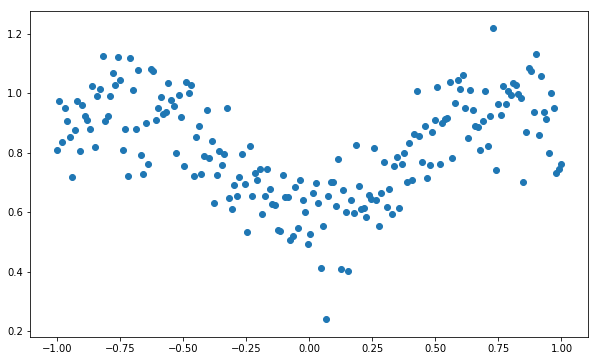

In [2]:
LR = 0.1

# 真实参数
REAL_PARAMS = [1.2, 2.5]
# 测试参数
INIT_PARAMS = [[5,4],
              [5,1],
                [2,4.5]][2]

# 生成x数据
x = np.linspace(-1, 1, 200, dtype=np.float32)

# test 1  简单的线性函数
# y_fun = lambda a, b: a * x + b
# tf_y_fun = lambda a, b: a * x + b

# test2  稍微复杂一点的函数,经验公式调参
# y_fun = lambda a, b: a * x**3 + b * x**2
# tf_y_fun = lambda a, b: a * x**3 + b * x**2

# test3 解释局部最优
y_fun = lambda a, b: np.sin(b*np.cos(a*x))
tf_y_fun = lambda a, b: tf.sin(b*tf.cos(a*x))

noise = np.random.randn(200)/10
# 生成y数据，（训练标签数据）
y = y_fun(*REAL_PARAMS) + noise

#展示数据
plt.figure(figsize=(10,6))
plt.scatter(x,y)

In [3]:
# 初始化数据，这里的a，b想当于网络中的w，b，初始化之后，随着网络的训练会对其进行改变
a, b = [tf.Variable(initial_value=p, dtype=tf.float32) for p in INIT_PARAMS]
pred = tf_y_fun(a,b)
mse = tf.reduce_mean(tf.square(y-pred))
train_op = tf.train.GradientDescentOptimizer(LR).minimize(mse)

a_list,b_list, cost_list = [],[],[]
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for t in range(400):
        # 记录a_,b_的变化记录，以及mse的值的大小
        a_, b_, mse_ = sess.run([a, b, mse])
        a_list.append(a_)
        b_list.append(b_)
        cost_list.append(mse_)
        
        result, _ = sess.run([pred, train_op])

Instructions for updating:
Colocations handled automatically by placer.


a= 1.1806633  b= 2.5052545


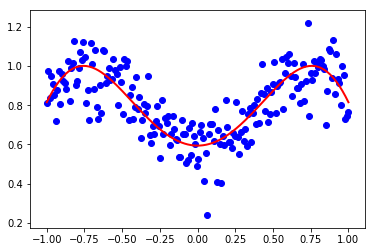

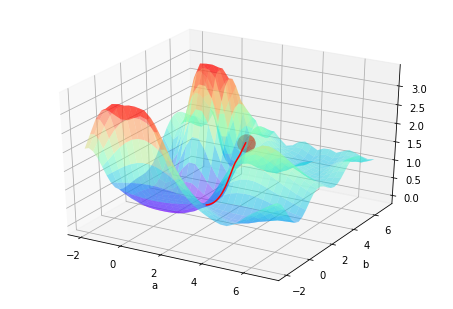

In [4]:
# 可视化代码
# 这一步是看拟合结果，即我们获得的a，b能否拟合数据
print('a=',a_,' b=',b_)
plt.figure(1)
plt.scatter(x,y, c='b')
plt.plot(x, result,'r-', lw=2)

# 3d cost figure
# 3d视角看误差如何下降
fig = plt.figure(2)
ax = Axes3D(fig)
# 两个参数轴形成的面
a3D, b3D = np.meshgrid(np.linspace(-2,7,30),np.linspace(-2,7,30))
# 计算对于每个参数值对，，mse的值，即mse在（a,b)的空间分布
cost3D = np.array([np.mean(np.square(y_fun(a_,b_) -y)) for a_,b_ in zip(a3D.flatten(), b3D.flatten())]).reshape(a3D.shape)
ax.plot_surface(a3D, b3D, cost3D, rstride=1, cstride=1, cmap=plt.get_cmap('rainbow'), alpha=0.5)
# 画出初始点
ax.scatter(a_list[0], b_list[0], zs=cost_list[0],s=300, c='r')
ax.set_xlabel('a');ax.set_ylabel('b')
# 画出轨迹
ax.plot(a_list, b_list, zs=cost_list, zdir='z', c='r')